## Import the Libraries

In [6]:
import os
import re
import gc
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold

from tqdm import tqdm
import time

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ignore warnings
warnings.filterwarnings('ignore')

# Garbage collection
gc.collect()

0

## Import the price dataset to get the information

In [7]:
df_house_price = pd.read_csv('/kaggle/input/home-prices/CSUSHPISA.csv')
df_house_price.head()

,observation_date,CSUSHPISA
0,1987-01-01,63.963
1,1987-02-01,64.423
2,1987-03-01,64.734
3,1987-04-01,65.130
4,1987-05-01,65.564


In [8]:
# Convert the date column to datetime format
df_house_price['observation_date'] = pd.to_datetime(df_house_price['observation_date'])

# Filter rows from 2004-01-01 to 2024-12-31
df_filtered = df_house_price[
    (df_house_price['observation_date'] >= '2004-01-01') &
    (df_house_price['observation_date'] <= '2024-12-31')
]

# Reset index for clean output
df_filtered = df_filtered.reset_index(drop=True)

# Show the result
print(df_filtered.head())

  observation_date  CSUSHPISA
0       2004-01-01    141.646
1       2004-02-01    143.191
2       2004-03-01    145.058
3       2004-04-01    146.593
4       2004-05-01    148.186


In [9]:
df_filtered.shape

(252, 2)

In [10]:
# Function to load and clean each dataset
def load_dataset(file_path, feature_name):
    """
    Load a dataset from CSV and perform basic cleaning
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure date column is properly formatted
    df['date'] = pd.to_datetime(df['observation_date'])
    
    # Rename the value column to a more descriptive name
    column_name = df.columns[1]  # The second column contains the values
    df = df.rename(columns={column_name: feature_name})
    
    # Drop the original date column
    df = df.drop('observation_date', axis=1)
    
    # Sort by date
    df = df.sort_values('date')
    
    return df[['date', feature_name]]


# Define file paths
data_files = {
    'FedFundsRate': '/kaggle/input/home-prices/FEDFUNDS.csv',
    'WarehouseConstructionPPI': '/kaggle/input/home-prices/PCU236221236221.csv',
    'CPI': '/kaggle/input/home-prices/CPIAUCSL.csv',
    'MortgageRate': '/kaggle/input/home-prices/MORTGAGE30US.csv',
    'UnemploymentRate': '/kaggle/input/home-prices/UNRATE.csv',
    'SP500': '/kaggle/input/home-prices/SP500.csv',
    'MedianIncome': '/kaggle/input/home-prices/MEHOINUSA672N.csv',
    'HousingPermits': '/kaggle/input/home-prices/PERMIT.csv',
    'HousingStarts': '/kaggle/input/home-prices/HOUST.csv',
    'GDP': '/kaggle/input/home-prices/GDPC1.csv',
    'HomePrice': '/kaggle/input/home-prices/CSUSHPISA.csv',
    'Population': '/kaggle/input/home-prices/POPTHM.csv'
}

# Load all datasets
dataframes = {}
for feature_name, file_path in data_files.items():
    try:
        dataframes[feature_name] = load_dataset(file_path, feature_name)
        print(f"Loaded {feature_name} with {len(dataframes[feature_name])} rows")
    except Exception as e:
        print(f"Error loading {feature_name}: {str(e)}")

Loaded FedFundsRate with 849 rows
Loaded WarehouseConstructionPPI with 243 rows
Loaded CPI with 938 rows
Loaded MortgageRate with 2819 rows
Loaded UnemploymentRate with 927 rows
Loaded SP500 with 2610 rows
Loaded MedianIncome with 40 rows
Loaded HousingPermits with 782 rows
Loaded HousingStarts with 794 rows
Loaded GDP with 312 rows
Loaded HomePrice with 457 rows
Loaded Population with 794 rows


In [11]:
# Create a master dataframe with monthly frequency
def create_monthly_master_df(start_year=2004, end_year=2024):
    """
    Create a master dataframe with monthly dates from start_year to end_year
    """
    # Create date range from start_year to end_year
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    
    # Create a date range with monthly frequency
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # MS = Month Start
    
    # Create a master dataframe with these dates
    master_df = pd.DataFrame({'date': date_range})
    
    return master_df

# Create master dataframe
master_df = create_monthly_master_df(2004, 2024)
print(f"Created master dataframe with {len(master_df)} rows")

Created master dataframe with 252 rows


In [12]:
# Function to merge each dataset into the master dataframe
def merge_into_master(master_df, feature_df, feature_name, method='ffill'):
    """
    Merge a feature dataframe into the master dataframe
    
    Parameters:
    - master_df: The master dataframe with monthly dates
    - feature_df: The feature dataframe to merge
    - feature_name: The name of the feature
    - method: How to handle missing values ('ffill', 'bfill', or None)
    
    Returns:
    - Updated master dataframe with the new feature
    """
    # Create a temporary dataframe for merging
    temp_df = feature_df.copy()
    
    # Convert the date column to month start to match master_df
    temp_df['date'] = temp_df['date'].dt.to_period('M').dt.to_timestamp()
    
    # For data with frequency less than monthly (e.g., quarterly or annual),
    # we'll get multiple rows per month in the master_df, so we take the last value
    if temp_df['date'].duplicated().any():
        temp_df = temp_df.drop_duplicates('date', keep='last')
    
    # Left merge with master_df to keep all master dates
    merged_df = pd.merge(master_df, temp_df, on='date', how='left')
    
    # Handle missing values based on method
    if method == 'ffill':
        merged_df[feature_name] = merged_df[feature_name].ffill()
    elif method == 'bfill':
        merged_df[feature_name] = merged_df[feature_name].bfill()
    
    return merged_df

# Merge all datasets into the master
for feature_name, feature_df in dataframes.items():
    # For annual data, use forward fill
    if feature_name in ['Population', 'MedianIncome']:
        master_df = merge_into_master(master_df, feature_df, feature_name, method='ffill')
    # For quarterly data, use forward fill
    elif feature_name in ['GDP']:
        master_df = merge_into_master(master_df, feature_df, feature_name, method='ffill')
    # For higher frequency data, use the last value in each month
    else:
        master_df = merge_into_master(master_df, feature_df, feature_name, method=None)
    
    print(f"Merged {feature_name} into master dataframe, now has {master_df.shape[1]} columns")

Merged FedFundsRate into master dataframe, now has 2 columns
Merged WarehouseConstructionPPI into master dataframe, now has 3 columns
Merged CPI into master dataframe, now has 4 columns
Merged MortgageRate into master dataframe, now has 5 columns
Merged UnemploymentRate into master dataframe, now has 6 columns
Merged SP500 into master dataframe, now has 7 columns
Merged MedianIncome into master dataframe, now has 8 columns
Merged HousingPermits into master dataframe, now has 9 columns
Merged HousingStarts into master dataframe, now has 10 columns
Merged GDP into master dataframe, now has 11 columns
Merged HomePrice into master dataframe, now has 12 columns
Merged Population into master dataframe, now has 13 columns


In [13]:
# Filter to our target date range
master_df = master_df[(master_df['date'] >= '2004-01-01') & (master_df['date'] <= '2024-12-31')]

# Create a year and month column for easier analysis
master_df['year'] = master_df['date'].dt.year
master_df['month'] = master_df['date'].dt.month

# Reorder columns with date, year, month first
cols = ['date', 'year', 'month'] + [col for col in master_df.columns if col not in ['date', 'year', 'month']]
master_df = master_df[cols]

# Print the final dataframe information
print("\nFinal dataframe shape:", master_df.shape)
print("\nColumns:", master_df.columns.tolist())
print("\nSample of first few rows:")
print(master_df.head())

# Check for missing values
missing_values = master_df.isnull().sum()
print("\nMissing values by column:")
print(missing_values[missing_values > 0])

# Save the final dataframe to CSV
master_df.to_csv('economic_indicators_2004_2025.csv', index=False)
print("\nSaved final dataframe to economic_indicators_2004_2025.csv")


Final dataframe shape: (252, 15)

Columns: ['date', 'year', 'month', 'FedFundsRate', 'WarehouseConstructionPPI', 'CPI', 'MortgageRate', 'UnemploymentRate', 'SP500', 'MedianIncome', 'HousingPermits', 'HousingStarts', 'GDP', 'HomePrice', 'Population']

Sample of first few rows:
        date  year  month  FedFundsRate  WarehouseConstructionPPI    CPI  \
0 2004-01-01  2004      1          1.00                       NaN  186.3   
1 2004-02-01  2004      2          1.01                       NaN  186.7   
2 2004-03-01  2004      3          1.00                       NaN  187.1   
3 2004-04-01  2004      4          1.00                       NaN  187.4   
4 2004-05-01  2004      5          1.00                       NaN  188.2   

   MortgageRate  UnemploymentRate  SP500  MedianIncome  HousingPermits  \
0          5.68               5.7    NaN       68250.0            1952   
1          5.58               5.6    NaN       68250.0            1966   
2          5.40               5.8    NaN   

In [14]:
master_df['date']

0     2004-01-01
1     2004-02-01
2     2004-03-01
3     2004-04-01
4     2004-05-01
         ...    
247   2024-08-01
248   2024-09-01
249   2024-10-01
250   2024-11-01
251   2024-12-01
Name: date, Length: 252, dtype: datetime64[ns]

## Import the Resultant Dataset

In [15]:
df = pd.read_csv('/kaggle/working/economic_indicators_2004_2025.csv')

In [16]:
df.head()

,date,year,month,FedFundsRate,WarehouseConstructionPPI,CPI,MortgageRate,UnemploymentRate,SP500,MedianIncome,HousingPermits,HousingStarts,GDP,HomePrice,Population
0,2004-01-01,2004,1,1.00,NaN,186.3,5.68,5.7,NaN,68250.0,1952,1911,15248.68,141.646,292046
1,2004-02-01,2004,2,1.01,NaN,186.7,5.58,5.6,NaN,68250.0,1966,1846,15248.68,143.191,292230
2,2004-03-01,2004,3,1.00,NaN,187.1,5.40,5.8,NaN,68250.0,2066,1998,15248.68,145.058,292434
3,2004-04-01,2004,4,1.00,NaN,187.4,6.01,5.6,NaN,68250.0,2070,2003,15366.85,146.593,292651
4,2004-05-01,2004,5,1.00,NaN,188.2,6.32,5.6,NaN,68250.0,2150,1981,15366.85,148.186,292872


In [17]:
df.tail()

,date,year,month,FedFundsRate,WarehouseConstructionPPI,CPI,MortgageRate,UnemploymentRate,SP500,MedianIncome,HousingPermits,HousingStarts,GDP,HomePrice,Population
247,2024-08-01,2024,8,5.33,233.996,314.131,6.35,4.2,5648.40,80610.0,1470,1379,23400.294,322.299,340637
248,2024-09-01,2024,9,5.13,233.922,314.851,6.08,4.1,5762.48,80610.0,1425,1355,23400.294,323.311,340825
249,2024-10-01,2024,10,4.83,233.377,315.564,6.72,4.1,5705.45,80610.0,1419,1344,23542.349,324.491,341002
250,2024-11-01,2024,11,4.64,233.402,316.449,6.81,4.2,6032.38,80610.0,1493,1305,23542.349,326.013,341169
251,2024-12-01,2024,12,4.48,234.110,317.603,6.85,4.1,5881.63,80610.0,1482,1526,23542.349,327.582,341320


In [18]:
df.isnull().sum()

date                          0
year                          0
month                         0
FedFundsRate                  0
WarehouseConstructionPPI     11
CPI                           0
MortgageRate                  0
UnemploymentRate              0
SP500                       138
MedianIncome                  0
HousingPermits                0
HousingStarts                 0
GDP                           0
HomePrice                     0
Population                    0
dtype: int64

In [19]:
# Group by year and calculate mean of SP500
sp500_yearly_mean = df.groupby('year')['SP500'].mean()

# Display the results
print("Mean SP500 by Year:")
print(sp500_yearly_mean)

Mean SP500 by Year:
year
2004            NaN
2005            NaN
2006            NaN
2007            NaN
2008            NaN
2009            NaN
2010            NaN
2011            NaN
2012            NaN
2013            NaN
2014            NaN
2015    2050.641111
2016    2105.828333
2017    2465.200000
2018    2747.261818
2019    2937.961667
2020    3216.954167
2021    4285.544545
2022    4077.655000
2023    4322.654167
2024    5478.930909
Name: SP500, dtype: float64


In [20]:
# Group by year and calculate mean of SP500
sp500_yearly_mean = df.groupby('year')['WarehouseConstructionPPI'].mean()

# Display the results
print("Mean SP500 by Year:")
print(sp500_yearly_mean)

Mean SP500 by Year:
year
2004    100.000000
2005    104.483333
2006    112.300000
2007    118.975000
2008    124.391667
2009    126.950000
2010    123.575000
2011    126.400000
2012    131.158333
2013    134.666667
2014    138.000000
2015    140.550000
2016    142.858333
2017    146.958333
2018    152.075000
2019    159.525000
2020    162.041667
2021    174.364083
2022    223.492417
2023    234.114417
2024    233.702250
Name: WarehouseConstructionPPI, dtype: float64


In [21]:
# Group by year and month, then calculate mean of WarehouseConstructionPPI
warehouse_ppi_monthly = df.groupby(['year', 'month'])['WarehouseConstructionPPI'].mean()

# Display the results
print("Mean WarehouseConstructionPPI by Year and Month:")
print(warehouse_ppi_monthly)

Mean WarehouseConstructionPPI by Year and Month:
year  month
2004  1            NaN
      2            NaN
      3            NaN
      4            NaN
      5            NaN
                ...   
2024  8        233.996
      9        233.922
      10       233.377
      11       233.402
      12       234.110
Name: WarehouseConstructionPPI, Length: 252, dtype: float64


In [22]:
# Check the current state
null_count_before = df['WarehouseConstructionPPI'].isna().sum()
print(f"Number of null values before imputation: {null_count_before}")

# Calculate yearly means for WarehouseConstructionPPI (excluding null values)
yearly_means = df.groupby('year')['WarehouseConstructionPPI'].mean()
print("\nYearly means for WarehouseConstructionPPI:")
print(yearly_means)

# Find rows with null values
null_indices = df.index[df['WarehouseConstructionPPI'].isna()].tolist()
print(f"\nNumber of rows with null values: {len(null_indices)}")

Number of null values before imputation: 11

Yearly means for WarehouseConstructionPPI:
year
2004    100.000000
2005    104.483333
2006    112.300000
2007    118.975000
2008    124.391667
2009    126.950000
2010    123.575000
2011    126.400000
2012    131.158333
2013    134.666667
2014    138.000000
2015    140.550000
2016    142.858333
2017    146.958333
2018    152.075000
2019    159.525000
2020    162.041667
2021    174.364083
2022    223.492417
2023    234.114417
2024    233.702250
Name: WarehouseConstructionPPI, dtype: float64

Number of rows with null values: 11


In [23]:
# Set null values
for idx in null_indices:
    df.at[idx, 'WarehouseConstructionPPI'] = np.nan

# Calculate yearly means for imputation
yearly_means = df.groupby('year')['WarehouseConstructionPPI'].mean().to_dict()

# Check null values before imputation
null_count_before = df['WarehouseConstructionPPI'].isna().sum()
print(f"Number of null values before imputation: {null_count_before}")

# Apply the imputation based on year with a loading bar
print("\nPerforming imputation...")

# Get null indices for imputation
null_indices = df[df['WarehouseConstructionPPI'].isna()].index.tolist()

# Create progress bar
for idx in tqdm(null_indices, desc="Imputing values", ncols=100):
    year_val = df.loc[idx, 'year']
    # Use year-specific mean if year_val in yearly_means and not pd.isna(yearly_means[year_val])
    if year_val in yearly_means and not pd.isna(yearly_means[year_val]):
        imputed_value = yearly_means[year_val]
        # Apply the imputed value
        df.at[idx, 'WarehouseConstructionPPI'] = imputed_value
    
    # Small delay to visualize the progress bar movement (remove in production)
    time.sleep(0.1)

# Verify imputation worked
null_count_after = df['WarehouseConstructionPPI'].isna().sum()
print(f"\nNumber of null values after imputation: {null_count_after}")

Number of null values before imputation: 11

Performing imputation...


Imputing values: 100%|██████████████████████████████████████████████| 11/11 [00:01<00:00,  9.82it/s]


Number of null values after imputation: 0


In [24]:
categorical_columns = df.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
print(categorical_columns)

['date']


In [25]:
# Select numerical columns only
numeric_cols = df.select_dtypes(include='number')

# Filter for columns with more than 30 unique values
cols_with_many_uniques = [col for col in numeric_cols.columns if df[col].nunique() > 30]

print("Numeric columns with more than 30 unique values:")
print(cols_with_many_uniques)

Numeric columns with more than 30 unique values:
['FedFundsRate', 'WarehouseConstructionPPI', 'CPI', 'MortgageRate', 'UnemploymentRate', 'SP500', 'HousingPermits', 'HousingStarts', 'GDP', 'HomePrice', 'Population']


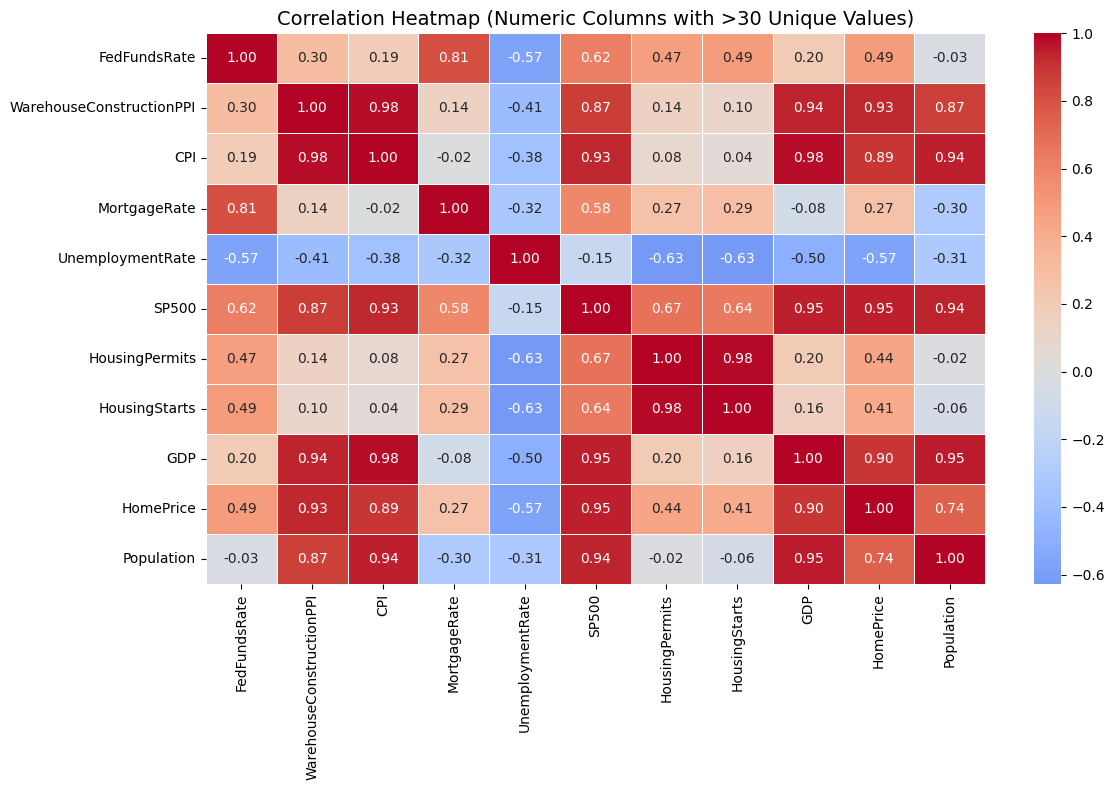

In [26]:
# Calculate correlation matrix
correlation_matrix = df[cols_with_many_uniques].corr()

# Set up the plot
plt.figure(figsize=(12, 8))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

# Title and show
plt.title("Correlation Heatmap (Numeric Columns with >30 Unique Values)", fontsize=14)
plt.tight_layout()
plt.show()

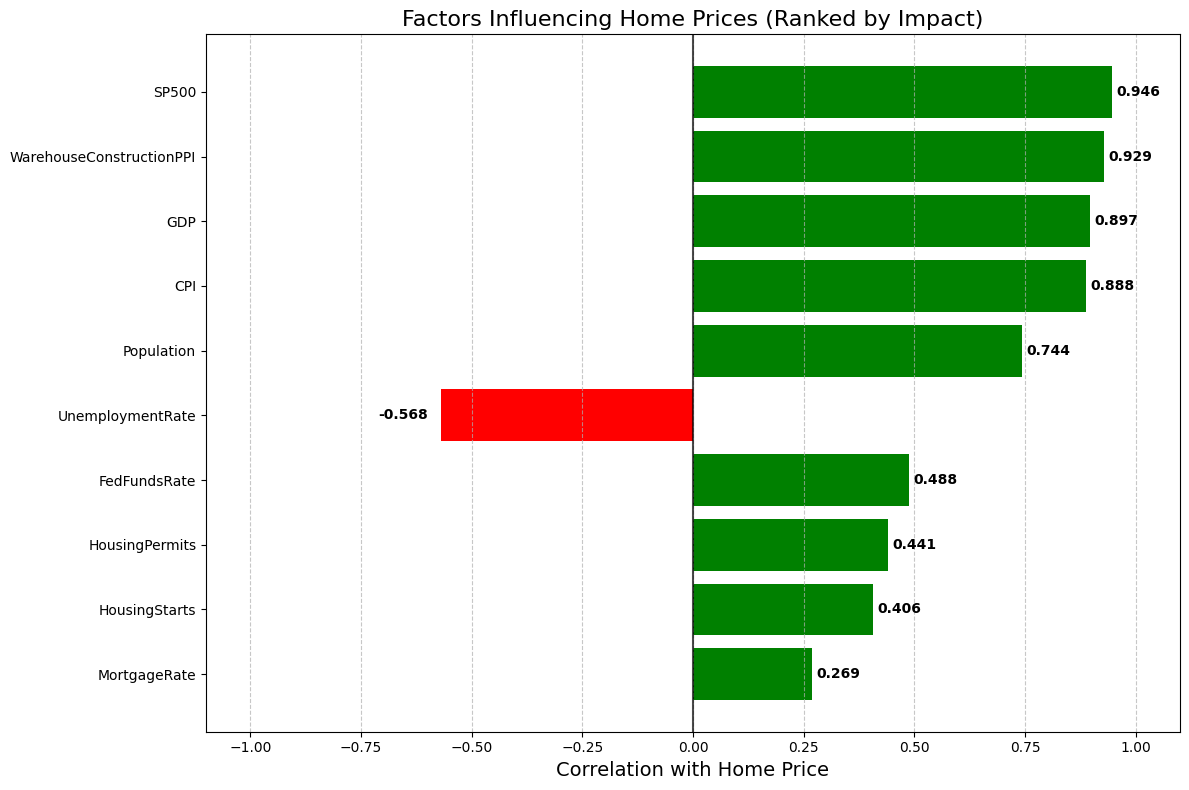

In [27]:
# Get correlations with HomePrice
home_price_correlations = correlation_matrix['HomePrice'].drop('HomePrice')

# Create a larger figure for better readability
plt.figure(figsize=(12, 8))

# Sort all correlations by absolute value
sorted_abs_corrs = home_price_correlations.abs().sort_values(ascending=True)
sorted_actual_corrs = home_price_correlations[sorted_abs_corrs.index]

# Create a horizontal bar chart
if len(sorted_actual_corrs) > 0:
    bars = plt.barh(
        sorted_abs_corrs.index, 
        sorted_actual_corrs,
        color=['green' if x > 0 else 'red' for x in sorted_actual_corrs]
    )

    # Add a zero line
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)

    # Add value labels at the end of each bar
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + 0.01 if width > 0 else width - 0.03
        plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                va='center', ha='left' if width > 0 else 'right', fontweight='bold')

    plt.xlabel('Correlation with Home Price', fontsize=14)
    plt.title('Factors Influencing Home Prices (Ranked by Impact)', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlim(-1.1, 1.1)
else:
    plt.text(0.5, 0.5, "No correlations to display", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.savefig('home_price_factors_ranked.png', dpi=300)
plt.show()

In [28]:
# Convert date to datetime for proper plotting
df['date'] = pd.to_datetime(df['date'])
# Select numerical columns only
numeric_cols = df.select_dtypes(include='number')

# Filter for columns with more than 30 unique values
cols_with_many_uniques = [col for col in numeric_cols.columns if df[col].nunique() >= 30]

print("Numeric columns with more than 30 unique values:")
print(cols_with_many_uniques)

Numeric columns with more than 30 unique values:
['FedFundsRate', 'WarehouseConstructionPPI', 'CPI', 'MortgageRate', 'UnemploymentRate', 'SP500', 'HousingPermits', 'HousingStarts', 'GDP', 'HomePrice', 'Population']


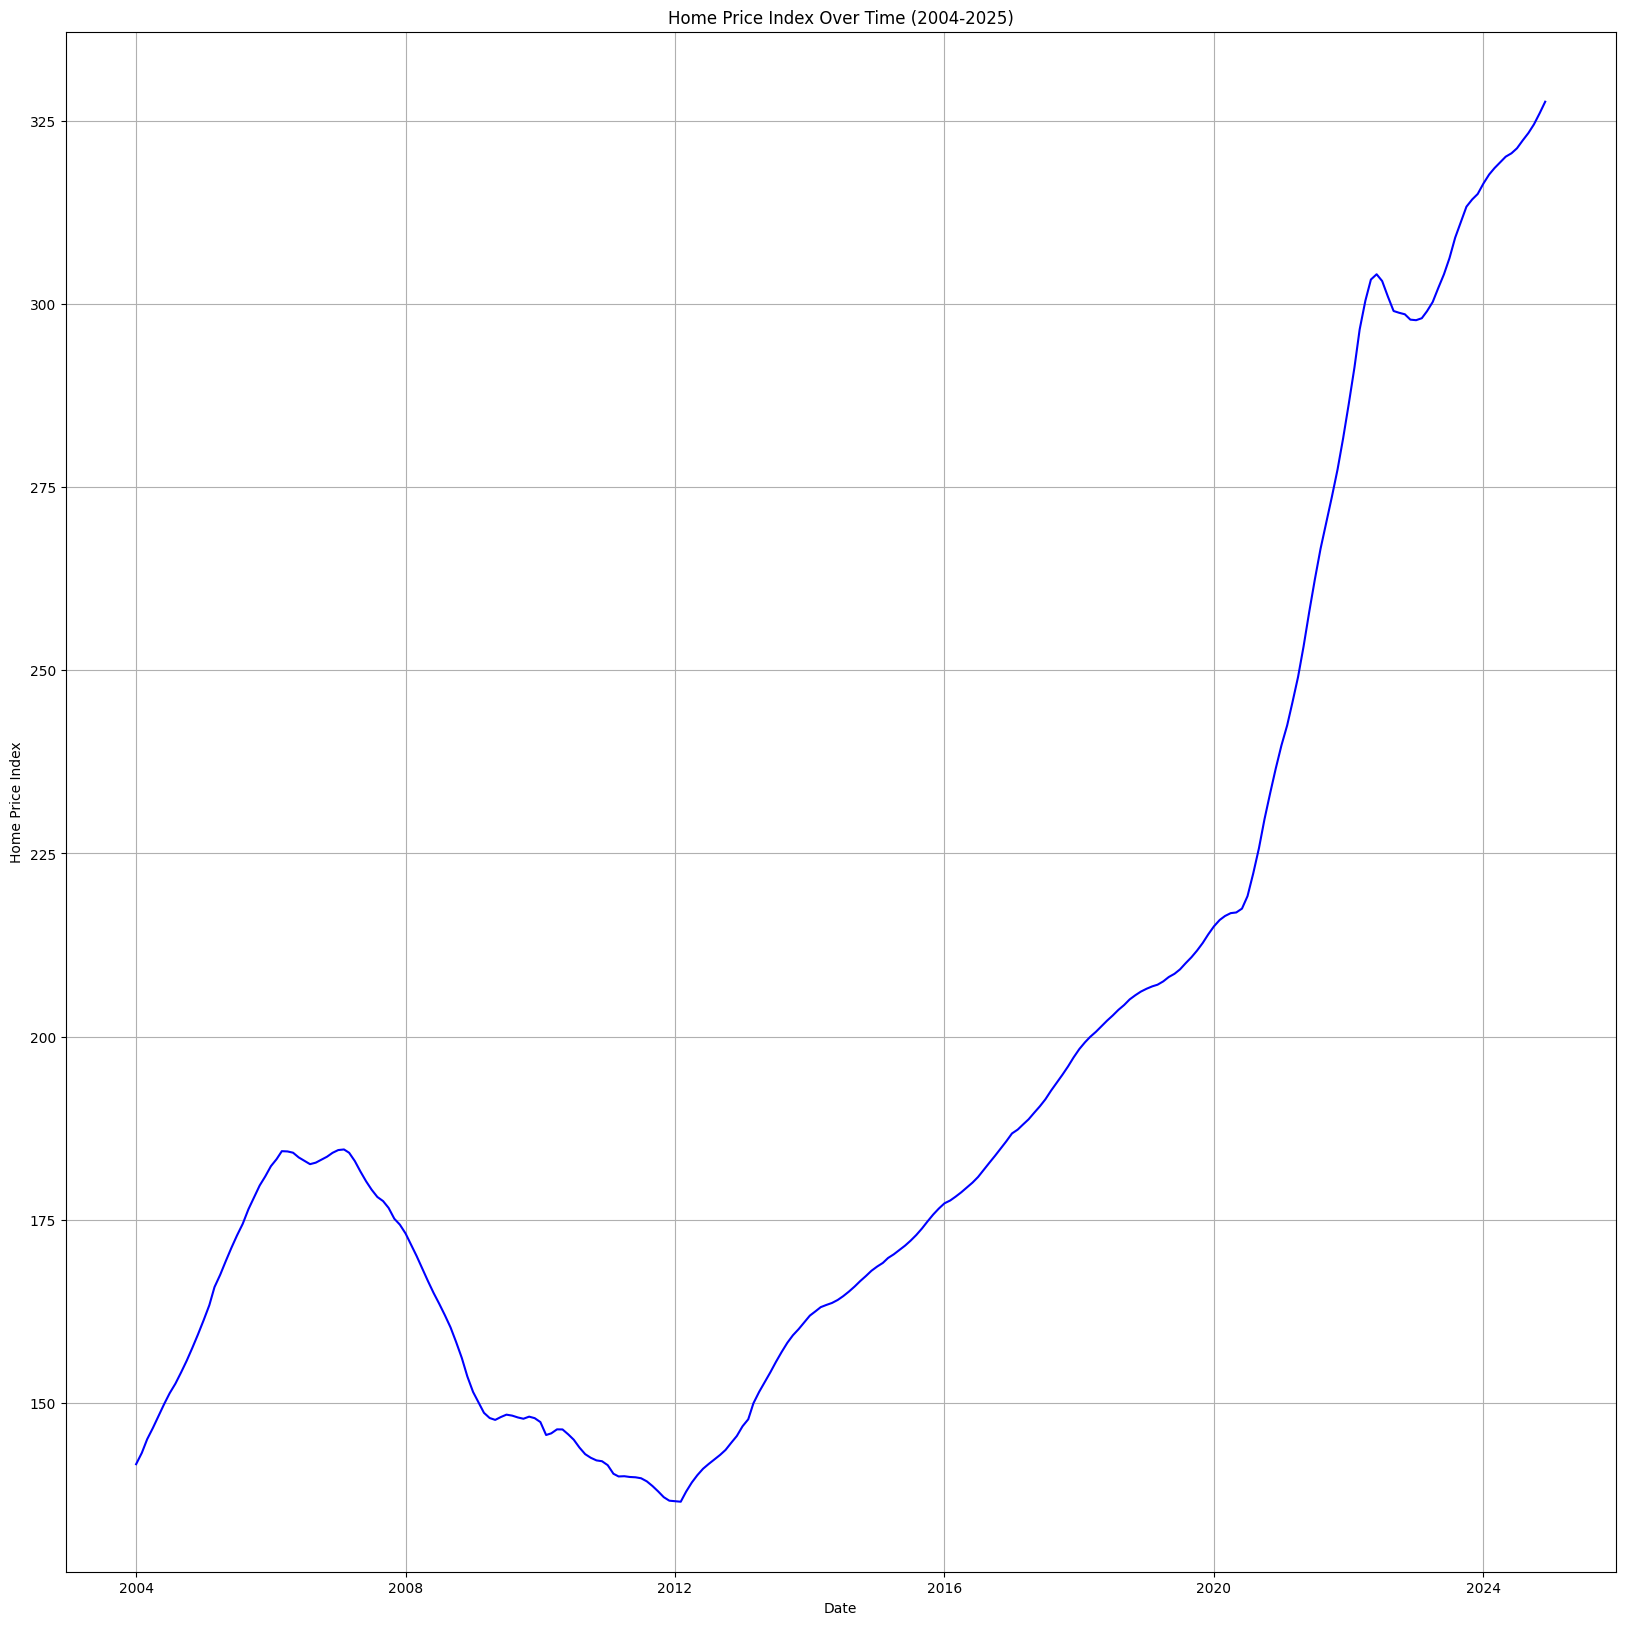

In [29]:
# Create a figure for all line plots
plt.figure(figsize=(20, 20))

# Home Price over Time
plt.plot(df['date'], df['HomePrice'], color='blue')
plt.title('Home Price Index Over Time (2004-2025)')
plt.xlabel('Date')
plt.ylabel('Home Price Index')
plt.grid(True)
plt.show()

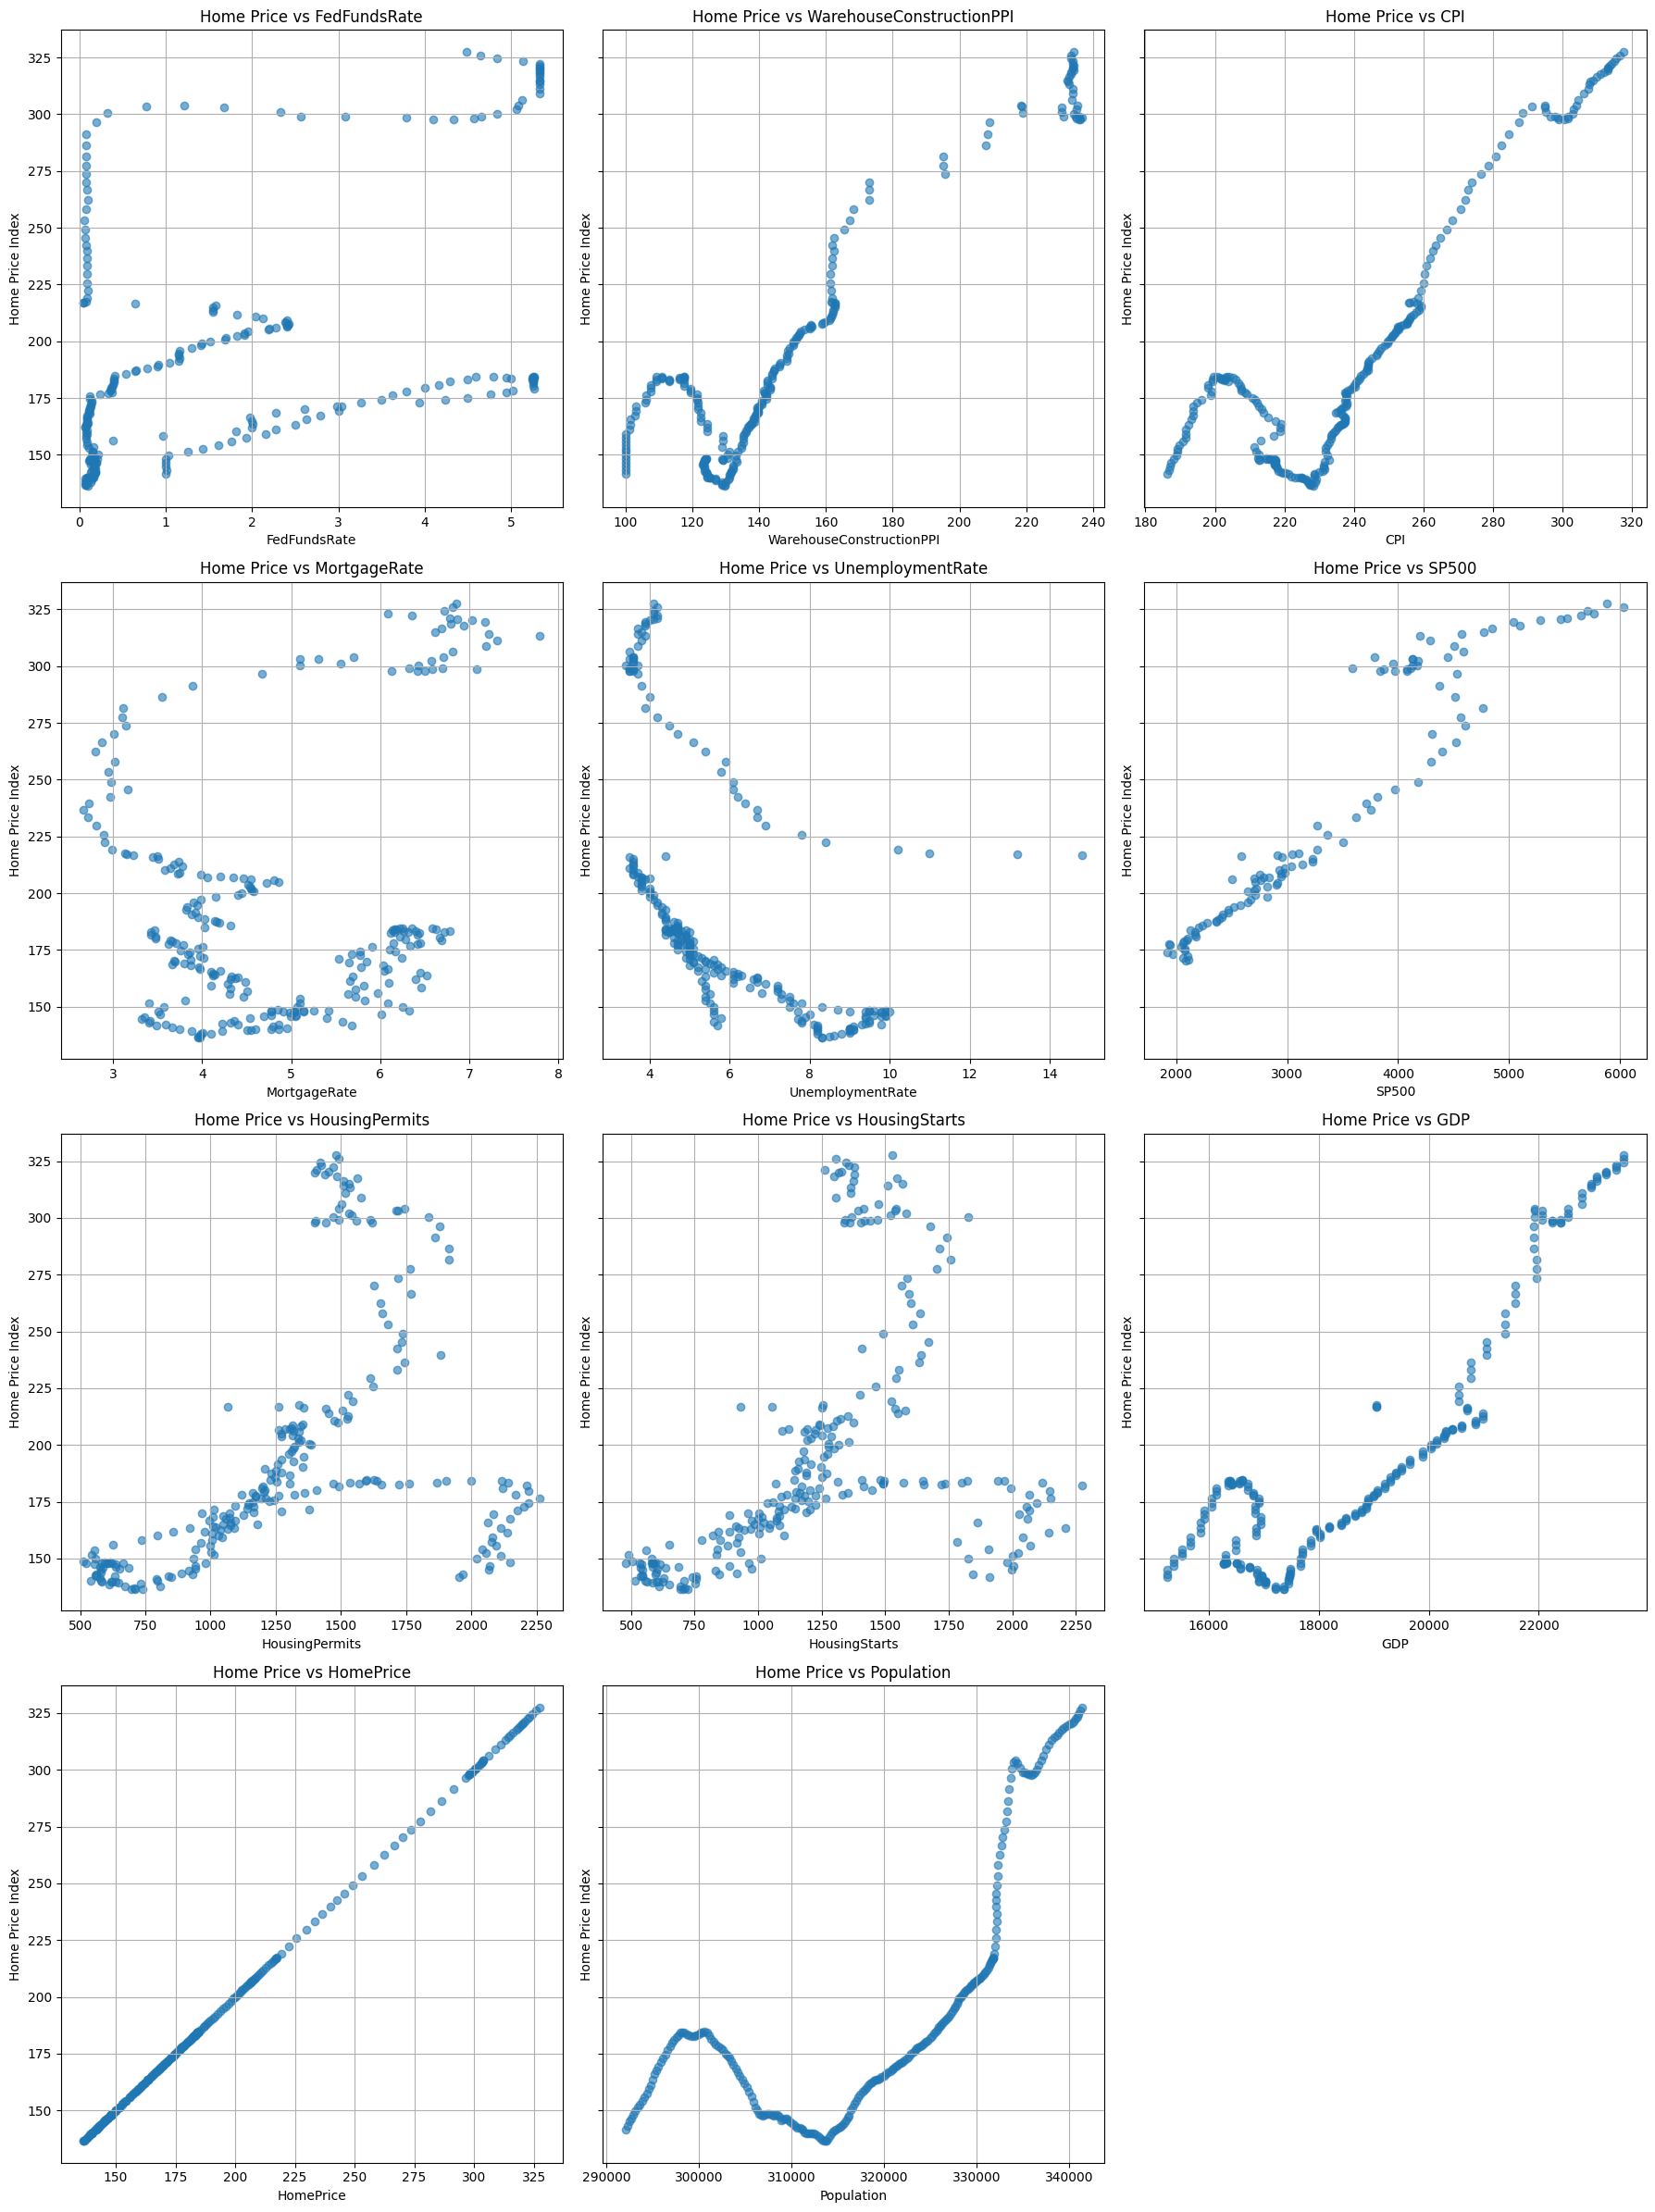

In [30]:
# Determine the number of columns for the grid
n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_with_many_uniques) + n_cols - 1) // n_cols  # Number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6 * n_rows), sharey=True)

# Flatten the axes array if it is multi-dimensional
axes = axes.flatten()

# Create scatter plots for each column
for i, col in enumerate(cols_with_many_uniques):
    # Use the appropriate axis from the grid
    ax = axes[i]
    
    # Create scatter plot on the current axis
    ax.scatter(df[col], df['HomePrice'], alpha=0.6)
    
    # Set titles and labels for the current subplot
    ax.set_title(f'Home Price vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Home Price Index')
    ax.grid(True)

# Hide any unused subplots
for j in range(len(cols_with_many_uniques), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

### According to scatterplot, homeprice has some linear relation with the CPI and GDP

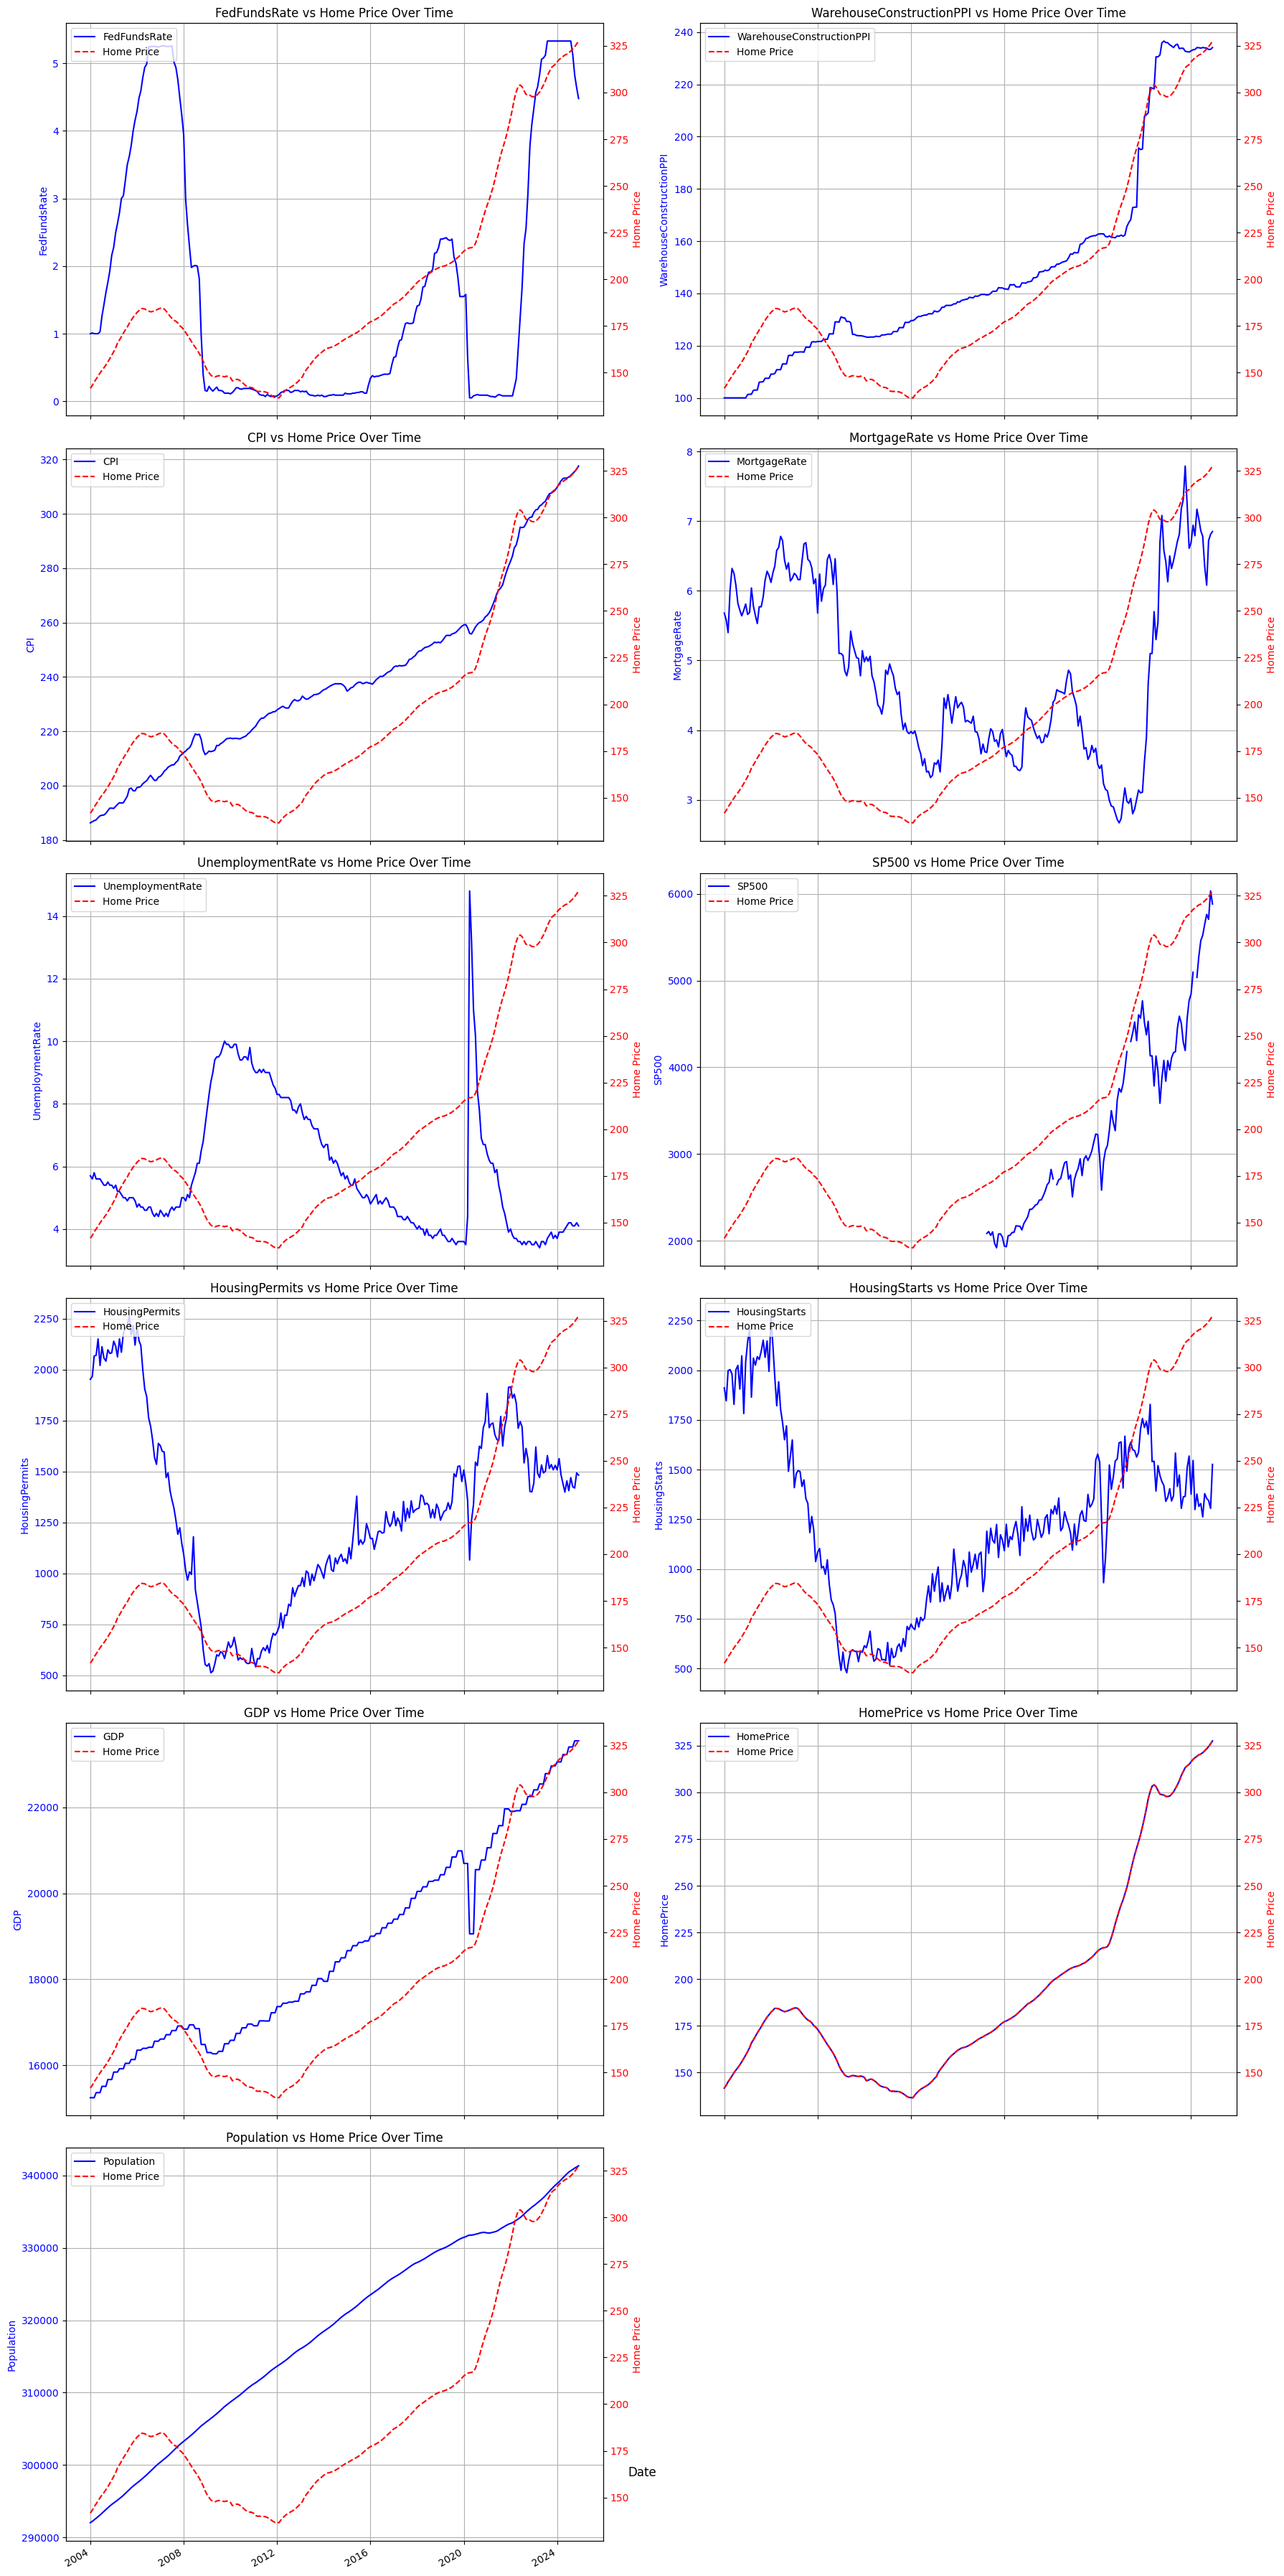

In [31]:
# Plot the most significant features against home prices over time in a 2-column grid
n_cols = 2  # Number of columns in the grid
n_rows = (len(cols_with_many_uniques) + n_cols - 1) // n_cols  # Number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

for i, feature in enumerate(cols_with_many_uniques):
    if i < len(axes):  # Make sure we don't exceed the number of subplots
        ax1 = axes[i]
        line1 = ax1.plot(df['date'], df[feature], color='blue', label=feature)
        ax1.set_ylabel(feature, color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        ax2 = ax1.twinx()
        line2 = ax2.plot(df['date'], df['HomePrice'], color='red', linestyle='--', label='Home Price')
        ax2.set_ylabel('Home Price', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add legend with lines from both axes
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')
        
        ax1.set_title(f'{feature} vs Home Price Over Time')
        ax1.grid(True)

# Hide any unused subplots
for j in range(len(cols_with_many_uniques), len(axes)):
    axes[j].set_visible(False)

# Format date ticks
fig.autofmt_xdate()

# Add a common x-label to the figure
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## According to this, with an increase in GDP, CPI, and Warehouse Construction PPI, home prices also increase.

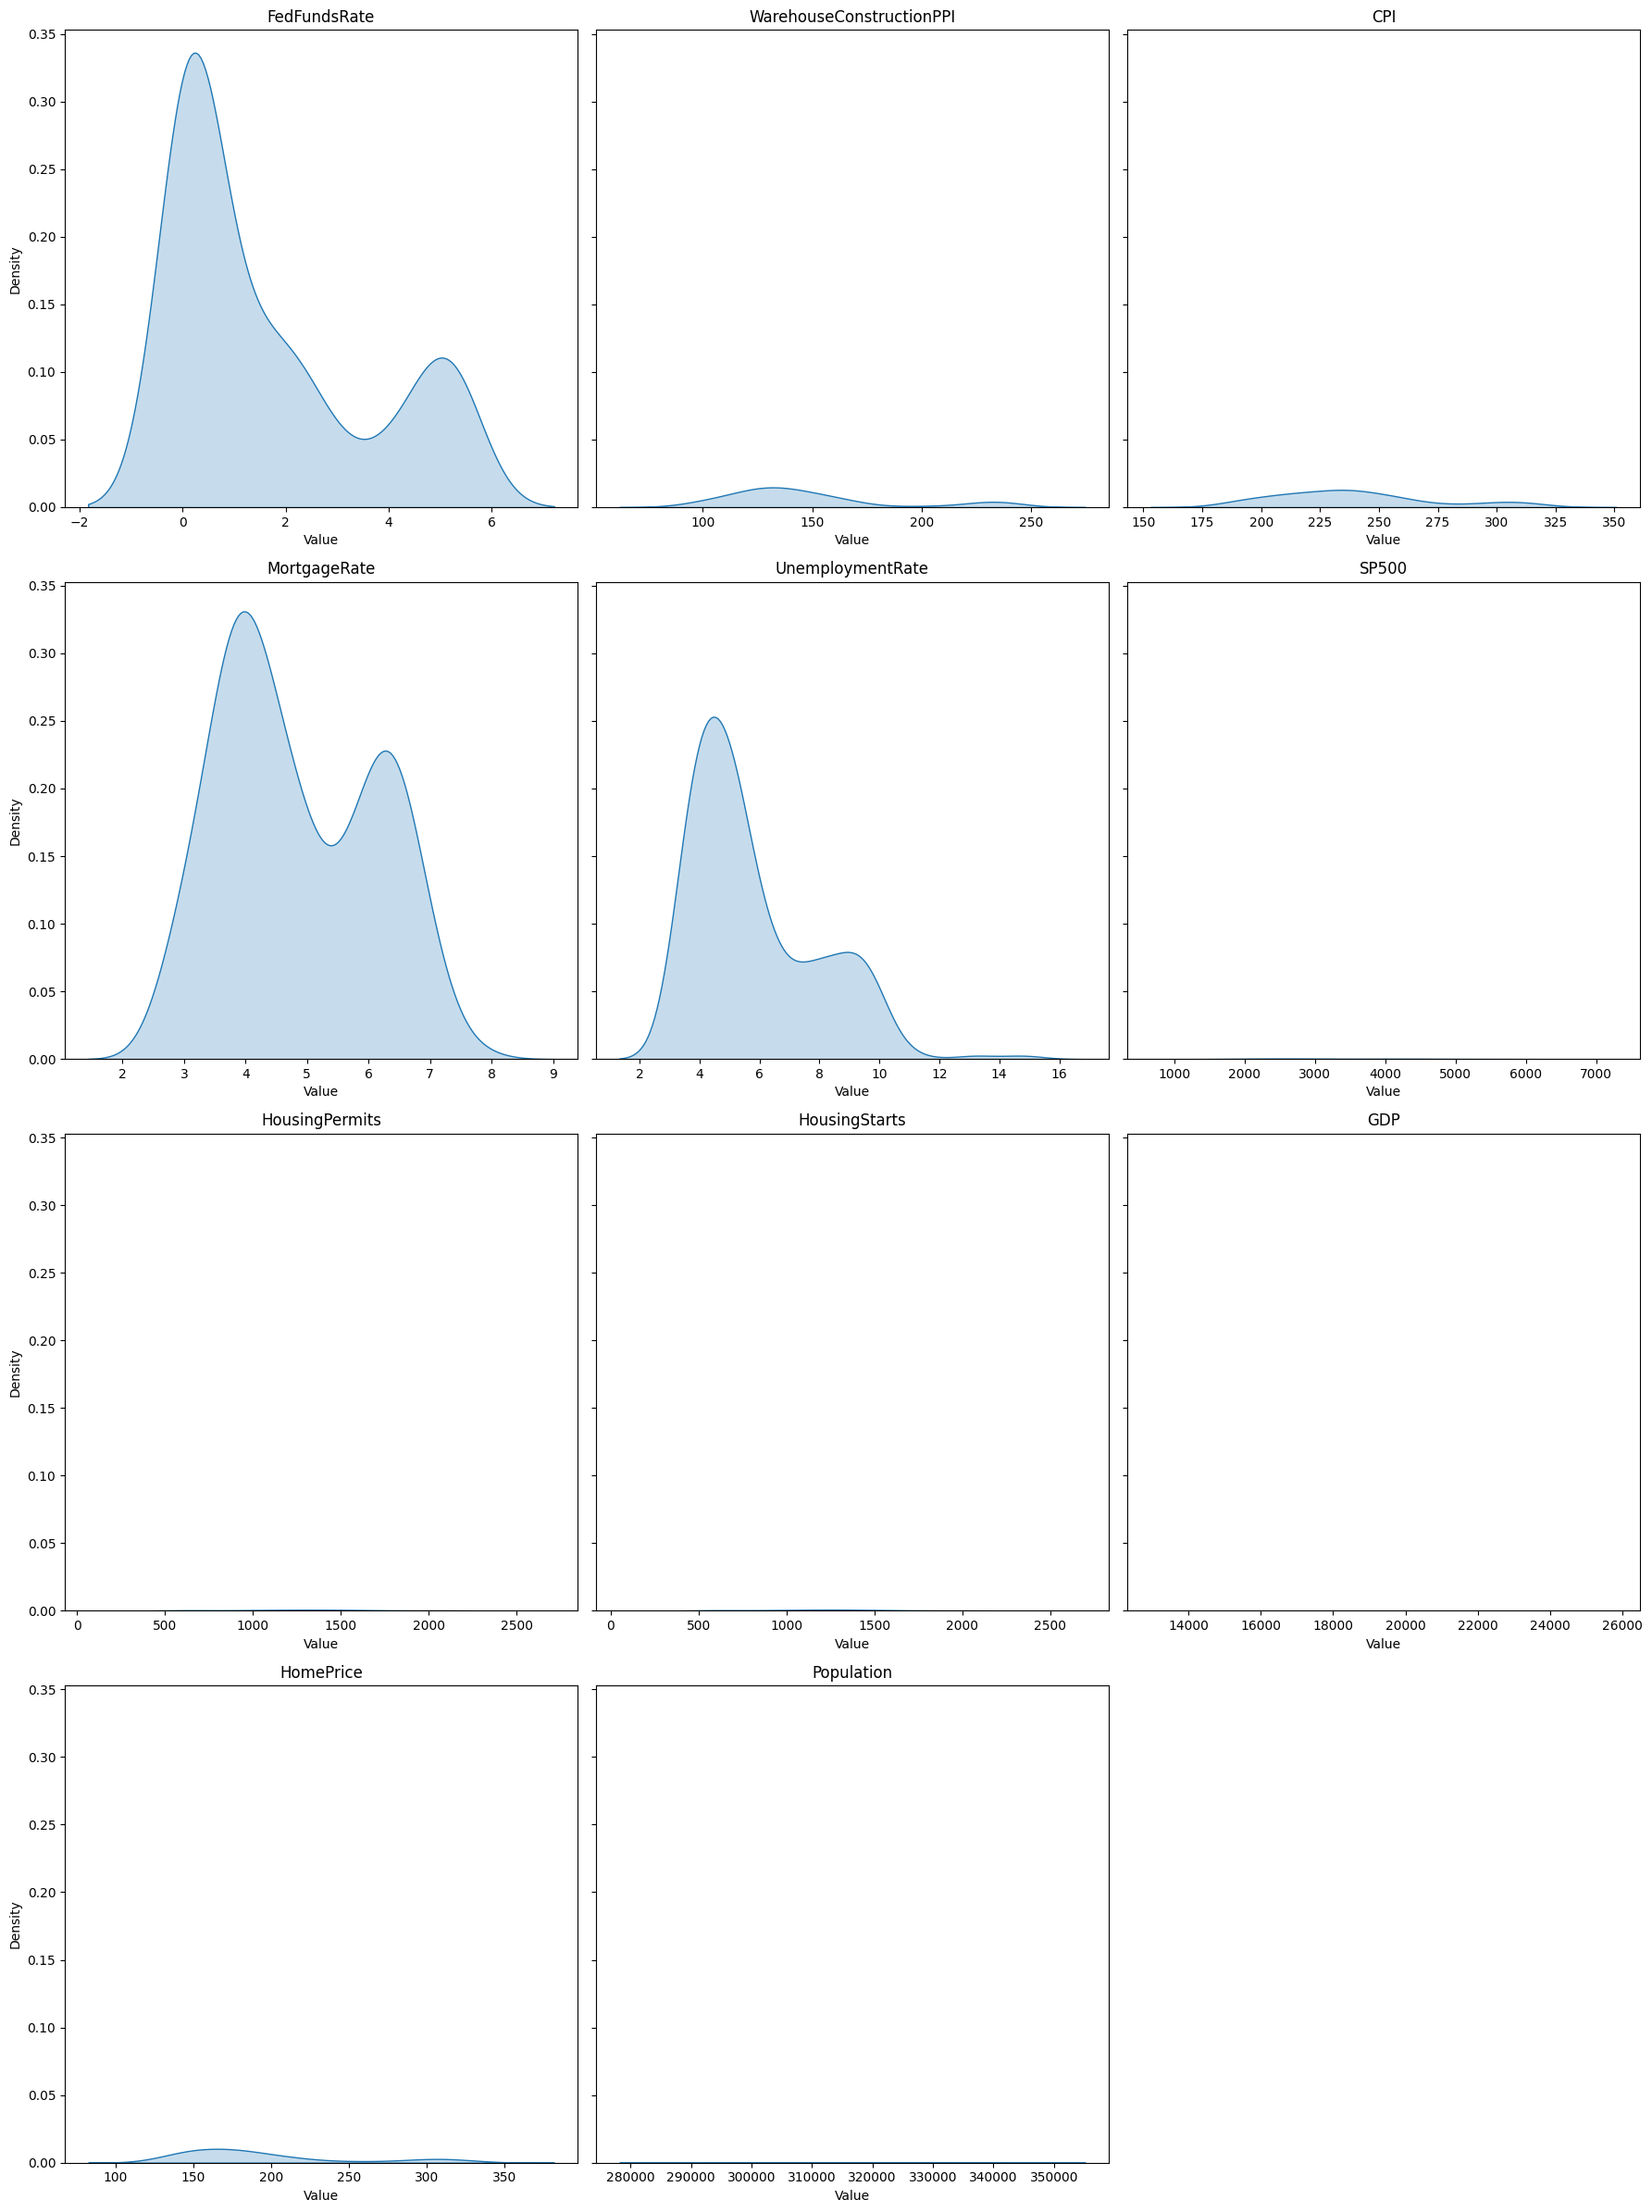

In [32]:
# Determine the number of columns for the grid
n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_with_many_uniques) + n_cols - 1) // n_cols  # Number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6 * n_rows), sharey=True)

# Flatten the axes array if it is multi-dimensional
axes = axes.flatten()

# Plot KDE for each numerical column
for ax, column in zip(axes, cols_with_many_uniques):
    sns.kdeplot(data=df, x=column, ax=ax, fill=True)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

# Turn off any unused subplots
for ax in axes[len(cols_with_many_uniques):]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [33]:
# Prepare features and target
X_train = df.drop(['HomePrice', 'date', 'year'], axis = 1)
y_train = df['HomePrice']

## Training the Model

In [34]:
lgbm_params_1 = {
    'verbosity': -1,
    'n_estimators': 25000,
    'random_state': 42,
    'reg_lambda': 9.738899198284985,
    'metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 8,
}

In [35]:
# Defining Configuration for k-fold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [36]:
# Initialize the lists to hold the cross-validation scores and feature importances
rmse_scores = []
r2_scores = []
feature_importances = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train), start=1):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model = LGBMRegressor(**lgbm_params_1)
    
    # Train the model on the current fold
    model.fit(X_train_fold, y_train_fold,
              eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)],
              callbacks=[lgb.log_evaluation(300), lgb.early_stopping(500)])
    
    # Predict on the validation set
    val_preds = model.predict(X_val_fold)
    
    # Calculate RMSE and R-squared for the current fold
    rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
    r2 = r2_score(y_val_fold, val_preds)
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    # Store the feature importances for this fold
    fold_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    })
    feature_importances.append(fold_importance)
    
    # Print fold results
    print(f"Fold {fold}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    print("\n" + "=" * 75 + "\n")

# Print overall results
print(f"\nAverage RMSE across folds: {np.mean(rmse_scores):.4f}")
print(f"Average R2 across folds: {np.mean(r2_scores):.4f}")

Training until validation scores don't improve for 500 rounds
[300]	training's rmse: 2.28758	valid_1's rmse: 2.89473
[600]	training's rmse: 1.31485	valid_1's rmse: 2.54506
[900]	training's rmse: 0.934935	valid_1's rmse: 2.3583
[1200]	training's rmse: 0.725197	valid_1's rmse: 2.3055
[1500]	training's rmse: 0.60482	valid_1's rmse: 2.31987
Early stopping, best iteration is:
[1076]	training's rmse: 0.794775	valid_1's rmse: 2.29998
Fold 1: RMSE = 2.3000, R2 = 0.9975


Training until validation scores don't improve for 500 rounds
[300]	training's rmse: 2.26847	valid_1's rmse: 3.09037
[600]	training's rmse: 1.2935	valid_1's rmse: 2.48809
[900]	training's rmse: 0.976006	valid_1's rmse: 2.28592
[1200]	training's rmse: 0.754883	valid_1's rmse: 2.20115
[1500]	training's rmse: 0.609937	valid_1's rmse: 2.18861
[1800]	training's rmse: 0.512711	valid_1's rmse: 2.19964
Early stopping, best iteration is:
[1567]	training's rmse: 0.585115	valid_1's rmse: 2.18675
Fold 2: RMSE = 2.1868, R2 = 0.9986


Train

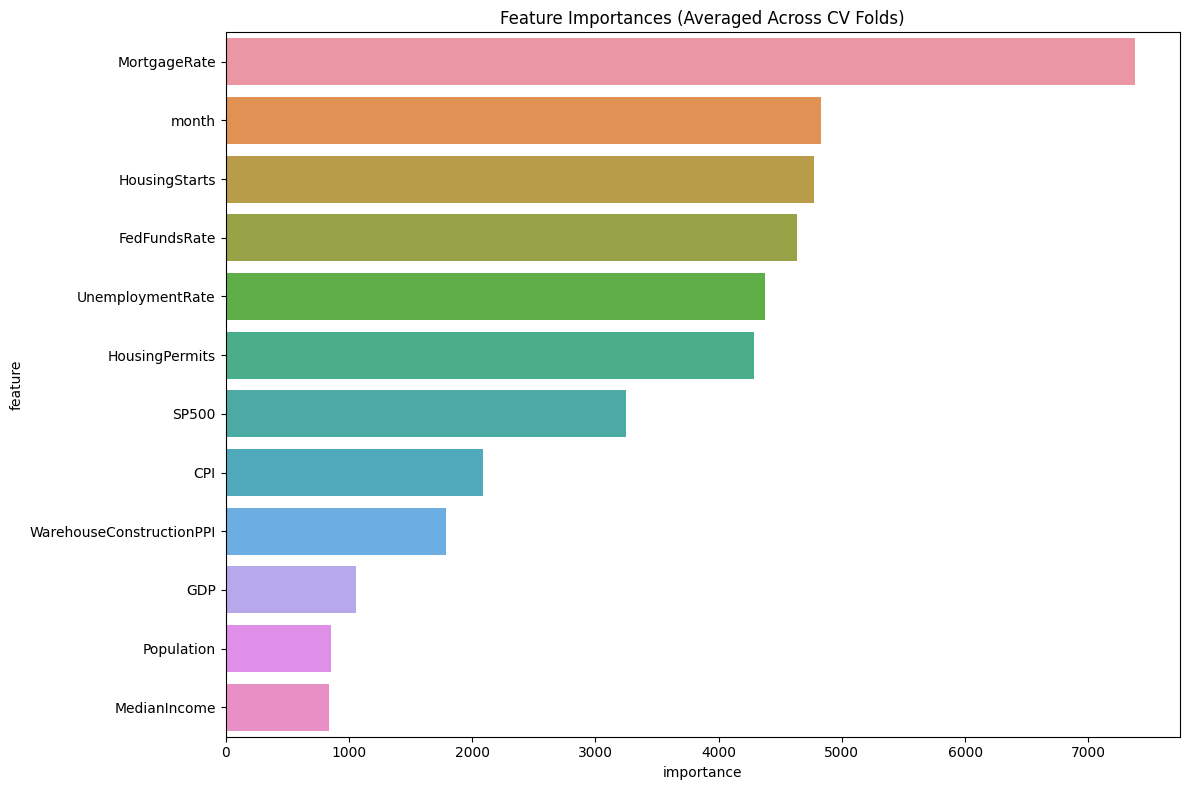

In [37]:
# Calculate average feature importance across all folds
all_importances = pd.concat(feature_importances)
avg_importance = all_importances.groupby('feature').importance.mean().reset_index()
avg_importance = avg_importance.sort_values('importance', ascending=False)

# Visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=avg_importance)
plt.title('Feature Importances (Averaged Across CV Folds)')
plt.tight_layout()
plt.show()

## According to feature importance, Mortgage rates, Housing Starts, Month, and the Fed Funds Rate have a greater influence on housing prices. Interestingly, some of the features with the highest correlation appear lower in importance, suggesting that while they are strongly correlated with housing prices, the model has identified more complex patterns and determined they are not as predictive.